In [2]:
import numpy as np
from scipy.linalg import expm, eig, norm
import matplotlib.pyplot as plt

In [3]:
# We define Pauli matices and a helper function for tensor products of Paulis for convenience to use later.
ident = np.array([[1, 0], [0, 1]])
pauli_x = np.array([[0, 1], [1, 0]])
pauli_y = np.array([[0, -1j], [1j, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

def pauli_product(pauli_string):
    """Helper method to compute kronecker product of Paulis"""

    prod = 1
    for p in pauli_string:
        if p == "I":
            prod = np.kron(prod, ident)
        elif p == "X":
            prod = np.kron(prod, pauli_x)
        elif p == "Y":
            prod = np.kron(prod, pauli_y)
        elif p == "Z":
            prod = np.kron(prod, pauli_z)

    return prod

def sortES(eigVals, eigVecs):
    """
    simple routine to sort eigenvectors given the eigenvalues
    """

    # Zip the associated eigenvalues and eigenvectors together and sort by eigenvalue
    eigSystem = sorted(zip(eigVals, np.transpose(eigVecs)), key = lambda x: x[0])
    eigValsOut = [eVal for eVal, _ in eigSystem]
    eigVecsOut = [eVec for _, eVec in eigSystem]

    return eigValsOut,eigVecsOut

def printstate(v, L, cutoff):
    """
    routine to print quantum states in human readable format.
    cutoff value will skip entries with small amplitudes
    """
    for i in range(1<<L):
        # index, binary repr, amplitudes, amplitudes squared
        if v[i] * np.conj(v[i]) > cutoff:
            print(f"{i}  -  {np.binary_repr(i, width=L)}  -  {v[i]}  -  {v[i]*np.conj(v[i])}")

def diag_H(H):
    eigVals,eigVecs = eig(H)
    eigVals,eigVecs = sortES(eigVals, eigVecs)
    en_exact = eigVals[0]

    print("\nGround state energy exact")
    print(np.real(en_exact))

    print(f"\nGap (Delta): {np.real(eigVals[1] - eigVals[0])}")

## 1. L qubit Hamiltonain

- Generalize the 2-qubit case and devise a method to construct an arbitrary $L$-qubit transverse field Ising Hamiltonian $H = - J \sum_i Z_i Z_{i+1} - h \sum_i Z_i - \Gamma \sum_i X_i$
- What is the ground state energy of an 8-qubit Hamiltonian, with
    - $J = 1$
    - $\Gamma = 1$
    - keeping as the local magnetic field strenght $h = 0.1$, i.e., adding an additional term $h \sum_i Z_i$
    - periodic boudary conditions

In [4]:
def gen_H(L : int, h : float, gamma : float, J : float):
    ### Generate Ising Hamiltonian
    # 
    # params:
    # - L : number of qubits
    # - h : local magnetic field strength
    # - J  
    ###

    if L < 2:
        raise ValueError()
    
    term1 = pauli_product('I' * L)
    term2 = term1.copy()
    term3 = term1.copy()

    for i in range(L-1):
        term1 += pauli_product('I' * i + 'ZZ' + 'I' * (L-2-i))
        term2 += pauli_product('I' * i + 'Z' + 'I' * (L-1-i))
        term3 += pauli_product('I' * i + 'X' + 'I' * (L-1-i))

    H_P = - J * term1
    H_Q = - h * term2 - gamma * term3

    return H_P, H_Q
    

In [5]:
L = 8
H_P, H_Q = gen_H(L, 0.1, 1, 1)

H = H_P + H_Q

eigVals,eigVecs = eig(H)
eigVals,eigVecs = sortES(eigVals, eigVecs)
en_exact = eigVals[0]

print("Spectrum exact")
print(np.real(eigVals[:1<<L]))
print("\nGround state energy exact")
print(np.real(en_exact))

print("\nGround state wf exact")
printstate(eigVecs[0], L, 0.001)

print(f"\nGap (Delta): {np.real(eigVals[1] - eigVals[0])}")

Spectrum exact
[-11.75309767 -11.01530012 -10.47192151 -10.41531116  -9.75940567
  -9.73932888  -9.13253982  -9.09596427  -8.90422835  -8.88760674
  -8.55628629  -8.47307323  -8.27075921  -8.17059776  -8.06040077
  -7.95735947  -7.74197444  -7.66043103  -7.64302659  -7.56139427
  -7.47295684  -7.44112945  -7.37550376  -7.23837617  -7.23406926
  -7.04193015  -6.94685315  -6.8874657   -6.82225451  -6.78453191
  -6.72491821  -6.66981672  -6.65965461  -6.49209473  -6.4093629
  -6.32012826  -6.20900599  -6.17814186  -6.15965447  -6.14903894
  -6.04818397  -5.96493365  -5.94643666  -5.7607634   -5.7333439
  -5.64428705  -5.63303215  -5.57547112  -5.46891856  -5.42413758
  -5.41631092  -5.29643855  -5.29104416  -5.28857448  -5.1755183
  -5.11320721  -5.07249982  -5.06940449  -4.98137591  -4.95961907
  -4.94456792  -4.88982743  -4.77086656  -4.74329967  -4.66573023
  -4.66094445  -4.61975639  -4.59188608  -4.50915384  -4.42958952
  -4.3669114   -4.34615651  -4.33156247  -4.29601087  -4.2414128

## 2. Time to solution (TTS)

- Define an Ising model with
    - $L = 8
    - $J = 1$
    - $\Gamma = 1$
    - keeping as the local magnetic field strenght $h = 0.1$, i.e., adding an additional term $h \sum_i Z_i$
    - periodic boudary conditions
- Compute the exact ground state of $H_P = - J \sum_i Z_i Z_{i+1} - h \sum_i Z_i$

In [6]:
L = 8

H_P, H_Q = gen_H(L, 0.1, 1.0, 1)

eigVals,eigVecs = eig(H_P)
eigVals,eigVecs = sortES(eigVals, eigVecs)

ground_state_exact = eigVecs[0]

print("\nGround state wf exact")
printstate(ground_state_exact, L, 0.001)


Ground state wf exact
0  -  00000000  -  1.0  -  1.0


- Compute the ground state of $H_P$ via quantum annealing for a range of annealing times $t_{\rm total} \in \{ 1, 1.1, \ldots, 10 \}$ with increments of 0.1 and a step size of $\Delta t = 0.1$
- Compute the success probability $p_\mathrm{success}$ at the end of the anneal
- Compute the time to solution (TTS) of each anneal as a function of $t_\mathrm{total}$
- Plot both $p_\mathrm{success}$ and TTS

In [7]:
L = 8

init_psi = np.ones(1<<L, dtype=complex)
init_psi /= norm(init_psi, 2)

In [8]:
def adiabatic_evolution(t, dt, H_P, H_Q):
    s = t / dt
    H_instant = (1.0 - s) * H_Q + s * H_P
    
    return expm(-1.j * t * H_instant)

In [10]:
# approximate adiabatic evolution changing the hamiltonian at each dt timestep
from tqdm import tqdm
H_P, H_Q = gen_H(L, 0.1, 1, 1)

taus = np.arange(1.0, 10.0, 0.1)
tts = np.zeros_like(taus)
p_success = np.zeros_like(taus)

p_target = 0.99
margin_of_error = 0.1

psi_temp = init_psi.copy()

time = 0.0
dt = 0.1
index = 0
for tau in tqdm(taus):
    n_dtpoints = int(tau / 0.1)
    t_array = np.linspace(0, tau, num=n_dtpoints, endpoint=False)

    while time < tau:
        U = adiabatic_evolution(time, tau, H_P, H_Q)
        psi_temp = np.matmul(U, psi_temp)
        time += dt


    # I think I am doing something wrong here
    p_success[index] = psi_temp[0]*np.conj(psi_temp[0])
    R_target = np.log(1 - p_target) / np.log(1 - p_success[index])

    tts[index] = tau * R_target
    index += 1

  0%|          | 0/90 [00:00<?, ?it/s]

/tmp/ipykernel_905/2198707318.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  p_success[index] = psi_temp[0]*np.conj(psi_temp[0])
100%|██████████| 90/90 [00:08<00:00, 11.05it/s]


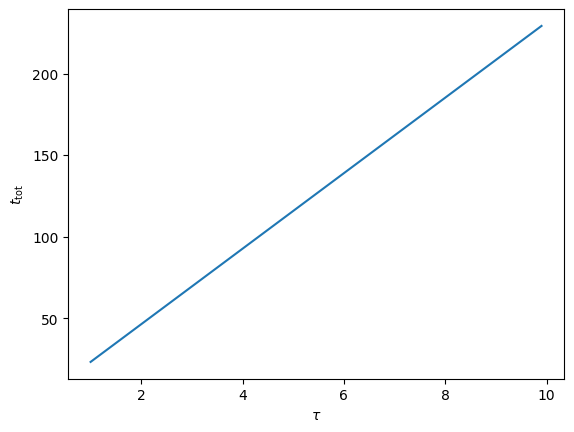

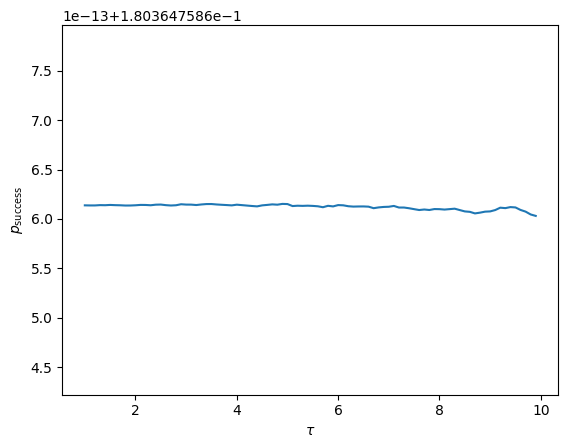

In [11]:
# plot results
plt.plot(taus, tts)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$t_{\mathrm{tot}}$')
plt.show()

plt.plot(taus, p_success)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$p_{\mathrm{success}}$')
plt.show()
